In [1]:
!pip install imblearn

  Using cached imblearn-0.0-py2.py3-none-any.whl (1.9 kB)
  Using cached imbalanced_learn-0.11.0-py3-none-any.whl (235 kB)
  Using cached joblib-1.3.1-py3-none-any.whl (301 kB)
  Attempting uninstall: joblib
    Found existing installation: joblib 1.1.0
    Uninstalling joblib-1.1.0:
      Successfully uninstalled joblib-1.1.0


In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.combine import SMOTETomek, SMOTEENN

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, classification_report, precision_recall_curve
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV, RandomizedSearchCV

from collections import Counter
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_parquet('imputed_dataset.parquet')

In [3]:
TARGET = 'Class'

X = df.drop(columns="Class")
y = df[TARGET]
RANDOM_STATE = 42

# Splitting the data into train and test
X_train,X_test,y_train,y_test=train_test_split(X, y, train_size=0.8, stratify = y, random_state=RANDOM_STATE)

In [4]:
y_train.shape, y_test.shape

((614,), (154,))

In [5]:
y_train.value_counts()/len(y_train)

0    0.651466
1    0.348534
Name: Class, dtype: float64

In [6]:
y_test.value_counts()/len(y_test)

0    0.649351
1    0.350649
Name: Class, dtype: float64

In [7]:
Scaler_X = StandardScaler()
X_train = Scaler_X.fit_transform(X_train)
X_test = Scaler_X.transform(X_test)

# Handling class imbalance using SMOTE based techniques

## A) SMOTE Technique

In [8]:
counter = Counter(y_train)
print('Before',counter)
# oversampling the train dataset using SMOTE
smt = SMOTE()
#X_train, y_train = smt.fit_resample(X_train, y_train)
X_train_sm, y_train_sm = smt.fit_resample(X_train, y_train)

counter = Counter(y_train_sm)
print('After',counter)

Before Counter({0: 400, 1: 214})
After Counter({0: 400, 1: 400})


## B) ADASYN Technique

In [9]:
counter = Counter(y_train)
print('Before',counter)
# oversampling the train dataset using ADASYN
ada = ADASYN(random_state=130)
X_train_ada, y_train_ada = ada.fit_resample(X_train, y_train)

counter = Counter(y_train_ada)
print('After',counter)

Before Counter({0: 400, 1: 214})
After Counter({1: 408, 0: 400})


## C) Hybrid Techniques

### C.1) SMOTE + Tomek Links

In [10]:
counter = Counter(y_train)
print('Before',counter)
# oversampling the train dataset using SMOTE + Tomek
smtom = SMOTETomek(random_state=139)
X_train_smtom, y_train_smtom = smtom.fit_resample(X_train, y_train)

counter = Counter(y_train_smtom)
print('After',counter)

Before Counter({0: 400, 1: 214})
After Counter({0: 379, 1: 379})


### C.2) SMOTE + ENN

In [11]:
counter = Counter(y_train)
print('Before',counter)
# oversampling the train dataset using SMOTE + ENN
smenn = SMOTEENN()
X_train_smenn, y_train_smenn = smenn.fit_resample(X_train, y_train)

counter = Counter(y_train_smenn)
print('After',counter)

Before Counter({0: 400, 1: 214})
After Counter({1: 237, 0: 207})


# Model Building - Imbalanced data

In [12]:
model = list()
resample = list()
precision = list()
recall = list()
F1score = list()
AUCROC = list()

In [13]:
def test_eval(clf_model, X_test, y_test, algo=None, sampling=None):
    # Test set prediction
    y_prob=clf_model.predict_proba(X_test)
    y_pred=clf_model.predict(X_test)

    print('Confusion Matrix')
    print('='*60)
    print(confusion_matrix(y_test,y_pred),"\n")
    print('Classification Report')
    print('='*60)
    print(classification_report(y_test,y_pred),"\n")
    print('AUC-ROC')
    print('='*60)
    print(roc_auc_score(y_test, y_prob[:,1]))
          
    model.append(algo)
    precision.append(precision_score(y_test,y_pred))
    recall.append(recall_score(y_test,y_pred))
    F1score.append(f1_score(y_test,y_pred))
    AUCROC.append(roc_auc_score(y_test, y_prob[:,1]))
    resample.append(sampling)

## Model-1: Logistic Regression

### 1. Original Unsampled Data

In [14]:
log_model=LogisticRegression()

params={'C':np.logspace(-10, 1, 15),'class_weight':[None,'balanced'],'penalty':['l1','l2']}

cv = StratifiedKFold(n_splits=5, random_state=RANDOM_STATE, shuffle=True)

# Create grid search using 5-fold cross validation
clf_LR = GridSearchCV(log_model, params, cv=cv, scoring='roc_auc', n_jobs=-1)
clf_LR.fit(X_train, y_train)
clf_LR.best_estimator_

LogisticRegression(C=1.6378937069540613, class_weight='balanced')

In [15]:
test_eval(clf_LR, X_test, y_test, 'Logistic Regression', 'actual')

Confusion Matrix
[[72 28]
 [18 36]] 

Classification Report
              precision    recall  f1-score   support

           0       0.80      0.72      0.76       100
           1       0.56      0.67      0.61        54

    accuracy                           0.70       154
   macro avg       0.68      0.69      0.68       154
weighted avg       0.72      0.70      0.71       154
 

AUC-ROC
0.8011111111111111


### 2.SMOTE Resampling

In [16]:
clf_LR.fit(X_train_sm, y_train_sm)
clf_LR.best_estimator_

LogisticRegression(C=1.6378937069540613)

In [17]:
test_eval(clf_LR, X_test, y_test, 'Logistic Regression', 'smote')

Confusion Matrix
[[76 24]
 [20 34]] 

Classification Report
              precision    recall  f1-score   support

           0       0.79      0.76      0.78       100
           1       0.59      0.63      0.61        54

    accuracy                           0.71       154
   macro avg       0.69      0.69      0.69       154
weighted avg       0.72      0.71      0.72       154
 

AUC-ROC
0.7975925925925926


### 3.ADASYN Resampling

In [18]:
clf_LR.fit(X_train_ada, y_train_ada)
clf_LR.best_estimator_

LogisticRegression(C=1.6378937069540613, class_weight='balanced')

In [19]:
test_eval(clf_LR, X_test, y_test, 'Logistic Regression', 'adasyn')

Confusion Matrix
[[71 29]
 [16 38]] 

Classification Report
              precision    recall  f1-score   support

           0       0.82      0.71      0.76       100
           1       0.57      0.70      0.63        54

    accuracy                           0.71       154
   macro avg       0.69      0.71      0.69       154
weighted avg       0.73      0.71      0.71       154
 

AUC-ROC
0.7988888888888889


### 4.SMOTE + Tomek Resampling

In [20]:
clf_LR.fit(X_train_smtom, y_train_smtom)
clf_LR.best_estimator_

LogisticRegression(C=10.0)

In [21]:
test_eval(clf_LR, X_test, y_test, 'Logistic Regression', 'smote+tomek')

Confusion Matrix
[[74 26]
 [19 35]] 

Classification Report
              precision    recall  f1-score   support

           0       0.80      0.74      0.77       100
           1       0.57      0.65      0.61        54

    accuracy                           0.71       154
   macro avg       0.68      0.69      0.69       154
weighted avg       0.72      0.71      0.71       154
 

AUC-ROC
0.8003703703703704


### 5.SMOTE + ENN Resampling

In [22]:
clf_LR.fit(X_train_smenn, y_train_smenn)
clf_LR.best_estimator_

LogisticRegression(C=1.6378937069540613)

In [23]:
test_eval(clf_LR, X_test, y_test, 'Logistic Regression', 'smote+enn')

Confusion Matrix
[[72 28]
 [16 38]] 

Classification Report
              precision    recall  f1-score   support

           0       0.82      0.72      0.77       100
           1       0.58      0.70      0.63        54

    accuracy                           0.71       154
   macro avg       0.70      0.71      0.70       154
weighted avg       0.73      0.71      0.72       154
 

AUC-ROC
0.8012962962962963


# Model-2: Decision Tree

In [24]:
estimators = [2,10,30,50,100]
# Maximum number of depth in each tree:
max_depth = [i for i in range(5,16,2)]
# Minimum number of samples to consider to split a node:
min_samples_split = [2, 5, 10, 15, 20, 50, 100]
# Minimum number of samples to consider at each leaf node:
min_samples_leaf = [1, 2, 5]

In [25]:
tree_model = DecisionTreeClassifier()

tree_param_grid = { 
    'max_depth': max_depth,
    'min_samples_split': min_samples_split,
    'min_samples_leaf': min_samples_leaf
}

clf_DT = RandomizedSearchCV(tree_model, tree_param_grid, cv=cv, scoring='roc_auc', n_jobs=-1, verbose=2)
clf_DT.fit(X_train, y_train)
clf_DT.best_estimator_

Fitting 5 folds for each of 10 candidates, totalling 50 fits


DecisionTreeClassifier(max_depth=5, min_samples_split=50)

In [26]:
test_eval(clf_DT, X_test, y_test, 'Decision Tree', 'actual')

Confusion Matrix
[[86 14]
 [33 21]] 

Classification Report
              precision    recall  f1-score   support

           0       0.72      0.86      0.79       100
           1       0.60      0.39      0.47        54

    accuracy                           0.69       154
   macro avg       0.66      0.62      0.63       154
weighted avg       0.68      0.69      0.68       154
 

AUC-ROC
0.7825000000000001


## 2.SMOTE Resampling

In [27]:
clf_DT.fit(X_train_sm, y_train_sm)
clf_DT.best_estimator_

Fitting 5 folds for each of 10 candidates, totalling 50 fits


DecisionTreeClassifier(max_depth=5, min_samples_split=10)

In [28]:
test_eval(clf_DT, X_test, y_test, 'Decision Tree', 'smote')

Confusion Matrix
[[78 22]
 [13 41]] 

Classification Report
              precision    recall  f1-score   support

           0       0.86      0.78      0.82       100
           1       0.65      0.76      0.70        54

    accuracy                           0.77       154
   macro avg       0.75      0.77      0.76       154
weighted avg       0.78      0.77      0.78       154
 

AUC-ROC
0.8007407407407408


## 3.ADASYN Resampling

In [29]:
clf_DT.fit(X_train_ada, y_train_ada)
clf_DT.best_estimator_

Fitting 5 folds for each of 10 candidates, totalling 50 fits


DecisionTreeClassifier(max_depth=13, min_samples_split=100)

In [30]:
test_eval(clf_DT, X_test, y_test, 'Decision Tree', 'adasyn')

Confusion Matrix
[[69 31]
 [12 42]] 

Classification Report
              precision    recall  f1-score   support

           0       0.85      0.69      0.76       100
           1       0.58      0.78      0.66        54

    accuracy                           0.72       154
   macro avg       0.71      0.73      0.71       154
weighted avg       0.75      0.72      0.73       154
 

AUC-ROC
0.7960185185185185


## 4. SMOTE + Tomek Resampling

In [31]:
clf_DT.fit(X_train_smtom, y_train_smtom)
clf_DT.best_estimator_

Fitting 5 folds for each of 10 candidates, totalling 50 fits


DecisionTreeClassifier(max_depth=13, min_samples_split=50)

In [32]:
test_eval(clf_DT, X_test, y_test, 'Decision Tree', 'smote+tomek')

Confusion Matrix
[[80 20]
 [21 33]] 

Classification Report
              precision    recall  f1-score   support

           0       0.79      0.80      0.80       100
           1       0.62      0.61      0.62        54

    accuracy                           0.73       154
   macro avg       0.71      0.71      0.71       154
weighted avg       0.73      0.73      0.73       154
 

AUC-ROC
0.7637962962962963


## 5.SMOTE + ENN Resampling

In [33]:
clf_DT.fit(X_train_smenn, y_train_smenn)
clf_DT.best_estimator_

Fitting 5 folds for each of 10 candidates, totalling 50 fits


DecisionTreeClassifier(max_depth=13, min_samples_leaf=2, min_samples_split=50)

In [34]:
test_eval(clf_DT, X_test, y_test, 'Decision Tree', 'smote+enn')

Confusion Matrix
[[62 38]
 [ 9 45]] 

Classification Report
              precision    recall  f1-score   support

           0       0.87      0.62      0.73       100
           1       0.54      0.83      0.66        54

    accuracy                           0.69       154
   macro avg       0.71      0.73      0.69       154
weighted avg       0.76      0.69      0.70       154
 

AUC-ROC
0.7949999999999999


# Model-3: Random Forest

## 1. Original Unsampled Data

In [35]:
rf_model = RandomForestClassifier()

rf_params={'n_estimators':estimators,
           'max_depth':max_depth,
           'min_samples_split':min_samples_split}

clf_RF = RandomizedSearchCV(rf_model, rf_params, cv=cv, scoring='roc_auc', n_jobs=-1, n_iter=20, verbose=2)
clf_RF.fit(X_train, y_train)
clf_RF.best_estimator_

Fitting 5 folds for each of 20 candidates, totalling 100 fits


RandomForestClassifier(max_depth=15, min_samples_split=50)

In [36]:
test_eval(clf_RF, X_test, y_test, 'Random Forest', 'actual')

Confusion Matrix
[[81 19]
 [25 29]] 

Classification Report
              precision    recall  f1-score   support

           0       0.76      0.81      0.79       100
           1       0.60      0.54      0.57        54

    accuracy                           0.71       154
   macro avg       0.68      0.67      0.68       154
weighted avg       0.71      0.71      0.71       154
 

AUC-ROC
0.7981481481481482


## 2.SMOTE Resampling

In [37]:
clf_RF.fit(X_train_sm, y_train_sm)
clf_RF.best_estimator_

Fitting 5 folds for each of 20 candidates, totalling 100 fits


RandomForestClassifier(max_depth=15, min_samples_split=5)

In [38]:
test_eval(clf_RF, X_test, y_test, 'Random Forest', 'smote')

Confusion Matrix
[[77 23]
 [17 37]] 

Classification Report
              precision    recall  f1-score   support

           0       0.82      0.77      0.79       100
           1       0.62      0.69      0.65        54

    accuracy                           0.74       154
   macro avg       0.72      0.73      0.72       154
weighted avg       0.75      0.74      0.74       154
 

AUC-ROC
0.8124074074074074


## 3.ADASYN Resampling

In [39]:
clf_RF.fit(X_train_ada, y_train_ada)
clf_RF.best_estimator_

Fitting 5 folds for each of 20 candidates, totalling 100 fits


RandomForestClassifier(max_depth=15, n_estimators=50)

In [40]:
test_eval(clf_RF, X_test, y_test, 'Random Forest', 'adasyn')

Confusion Matrix
[[73 27]
 [14 40]] 

Classification Report
              precision    recall  f1-score   support

           0       0.84      0.73      0.78       100
           1       0.60      0.74      0.66        54

    accuracy                           0.73       154
   macro avg       0.72      0.74      0.72       154
weighted avg       0.75      0.73      0.74       154
 

AUC-ROC
0.7950925925925927


## 4. SMOTE + Tomek Resampling

In [41]:
clf_RF.fit(X_train_smtom, y_train_smtom)
clf_RF.best_estimator_

Fitting 5 folds for each of 20 candidates, totalling 100 fits


RandomForestClassifier(max_depth=11, min_samples_split=5)

In [42]:
test_eval(clf_RF, X_test, y_test, 'Random Forest', 'smote+tomek')

Confusion Matrix
[[77 23]
 [13 41]] 

Classification Report
              precision    recall  f1-score   support

           0       0.86      0.77      0.81       100
           1       0.64      0.76      0.69        54

    accuracy                           0.77       154
   macro avg       0.75      0.76      0.75       154
weighted avg       0.78      0.77      0.77       154
 

AUC-ROC
0.8138888888888889


## 5. SMOTE + ENN Resampling

In [43]:
clf_RF.fit(X_train_smenn, y_train_smenn)
clf_RF.best_estimator_

Fitting 5 folds for each of 20 candidates, totalling 100 fits


RandomForestClassifier(max_depth=13, n_estimators=50)

In [44]:
test_eval(clf_RF, X_test, y_test, 'Random Forest', 'smote+enn')

Confusion Matrix
[[73 27]
 [12 42]] 

Classification Report
              precision    recall  f1-score   support

           0       0.86      0.73      0.79       100
           1       0.61      0.78      0.68        54

    accuracy                           0.75       154
   macro avg       0.73      0.75      0.74       154
weighted avg       0.77      0.75      0.75       154
 

AUC-ROC
0.7952777777777778


# Model Comparision

In [45]:
clf_eval_df = pd.DataFrame({'model':model,
                            'resample':resample,
                            'precision':precision,
                            'recall':recall,
                            'f1-score':F1score,
                            'AUC-ROC':AUCROC})

In [58]:
clf_eval_df.round(3)

,model,resample,precision,recall,f1-score,AUC-ROC
0,Logistic Regression,actual,0.562,0.667,0.610,0.801
1,Logistic Regression,smote,0.586,0.630,0.607,0.798
2,Logistic Regression,adasyn,0.567,0.704,0.628,0.799
3,Logistic Regression,smote+tomek,0.574,0.648,0.609,0.800
4,Logistic Regression,smote+enn,0.576,0.704,0.633,0.801
5,Decision Tree,actual,0.600,0.389,0.472,0.783
6,Decision Tree,smote,0.651,0.759,0.701,0.801
7,Decision Tree,adasyn,0.575,0.778,0.661,0.796
8,Decision Tree,smote+tomek,0.623,0.611,0.617,0.764
9,Decision Tree,smote+enn,0.542,0.833,0.657,0.795


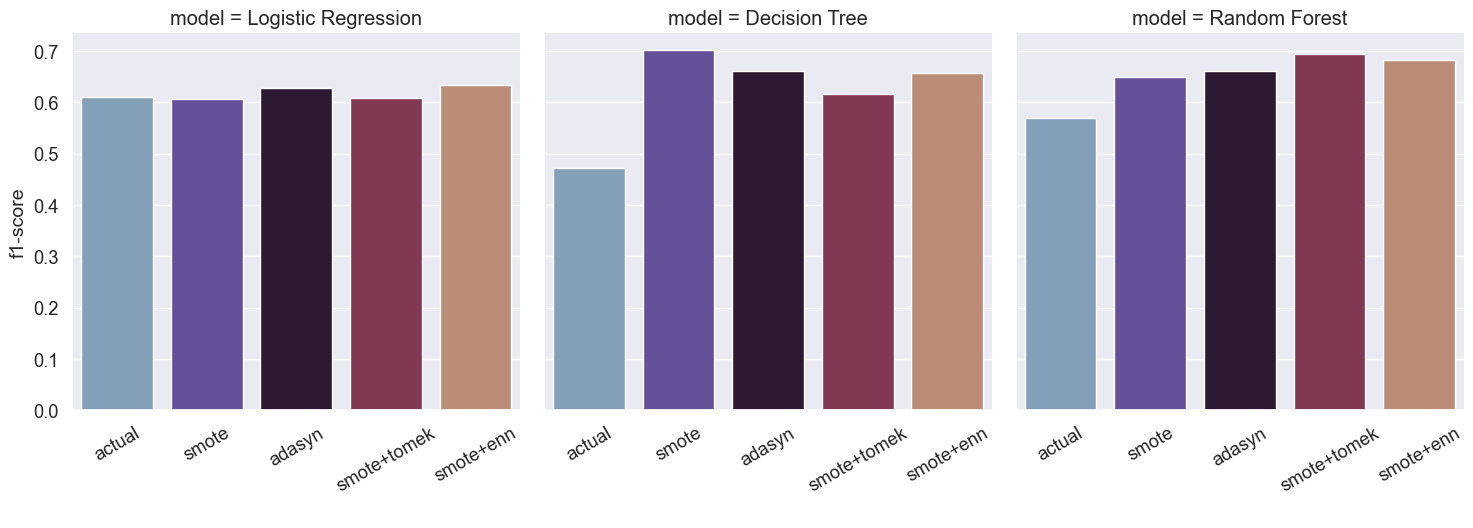

In [47]:
sns.set(font_scale=1.2)
g = sns.FacetGrid(clf_eval_df, col="model", height=5)
g.map(sns.barplot, "resample", "f1-score", palette='twilight', order=["actual", "smote", "adasyn", "smote+tomek", "smote+enn"])
g.set_xticklabels(rotation=30)
g.set_xlabels(' ', fontsize=14)
g.set_ylabels('f1-score', fontsize=14)

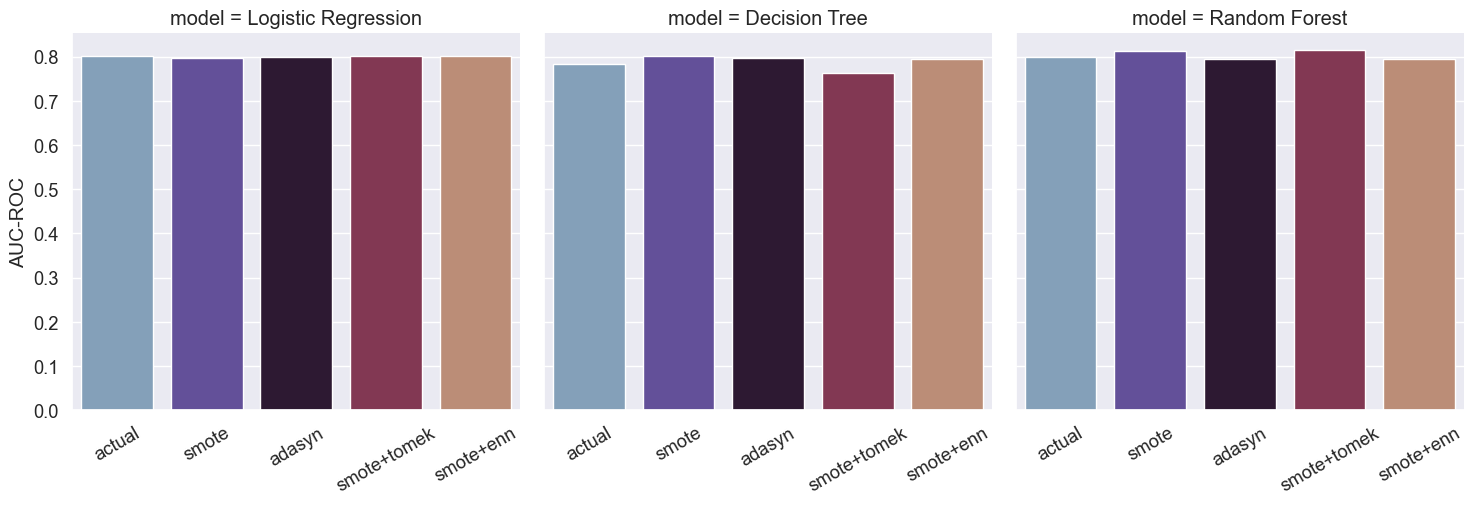

In [48]:
sns.set(font_scale=1.2)
g = sns.FacetGrid(clf_eval_df, col="model", height=5)
g.map(sns.barplot, "resample", "AUC-ROC", palette='twilight', order=["actual", "smote", "adasyn", "smote+tomek", "smote+enn"])
g.set_xticklabels(rotation=30)
g.set_xlabels(' ', fontsize=14)
g.set_ylabels('AUC-ROC', fontsize=14)

In [53]:
rf_featimp = RandomForestClassifier(max_depth=15, min_samples_leaf=2, min_samples_split=5)
rf_featimp.fit(X_train_sm, y_train_sm)

RandomForestClassifier(max_depth=15, min_samples_leaf=2, min_samples_split=5)

Creating and saving the feature importance curve!


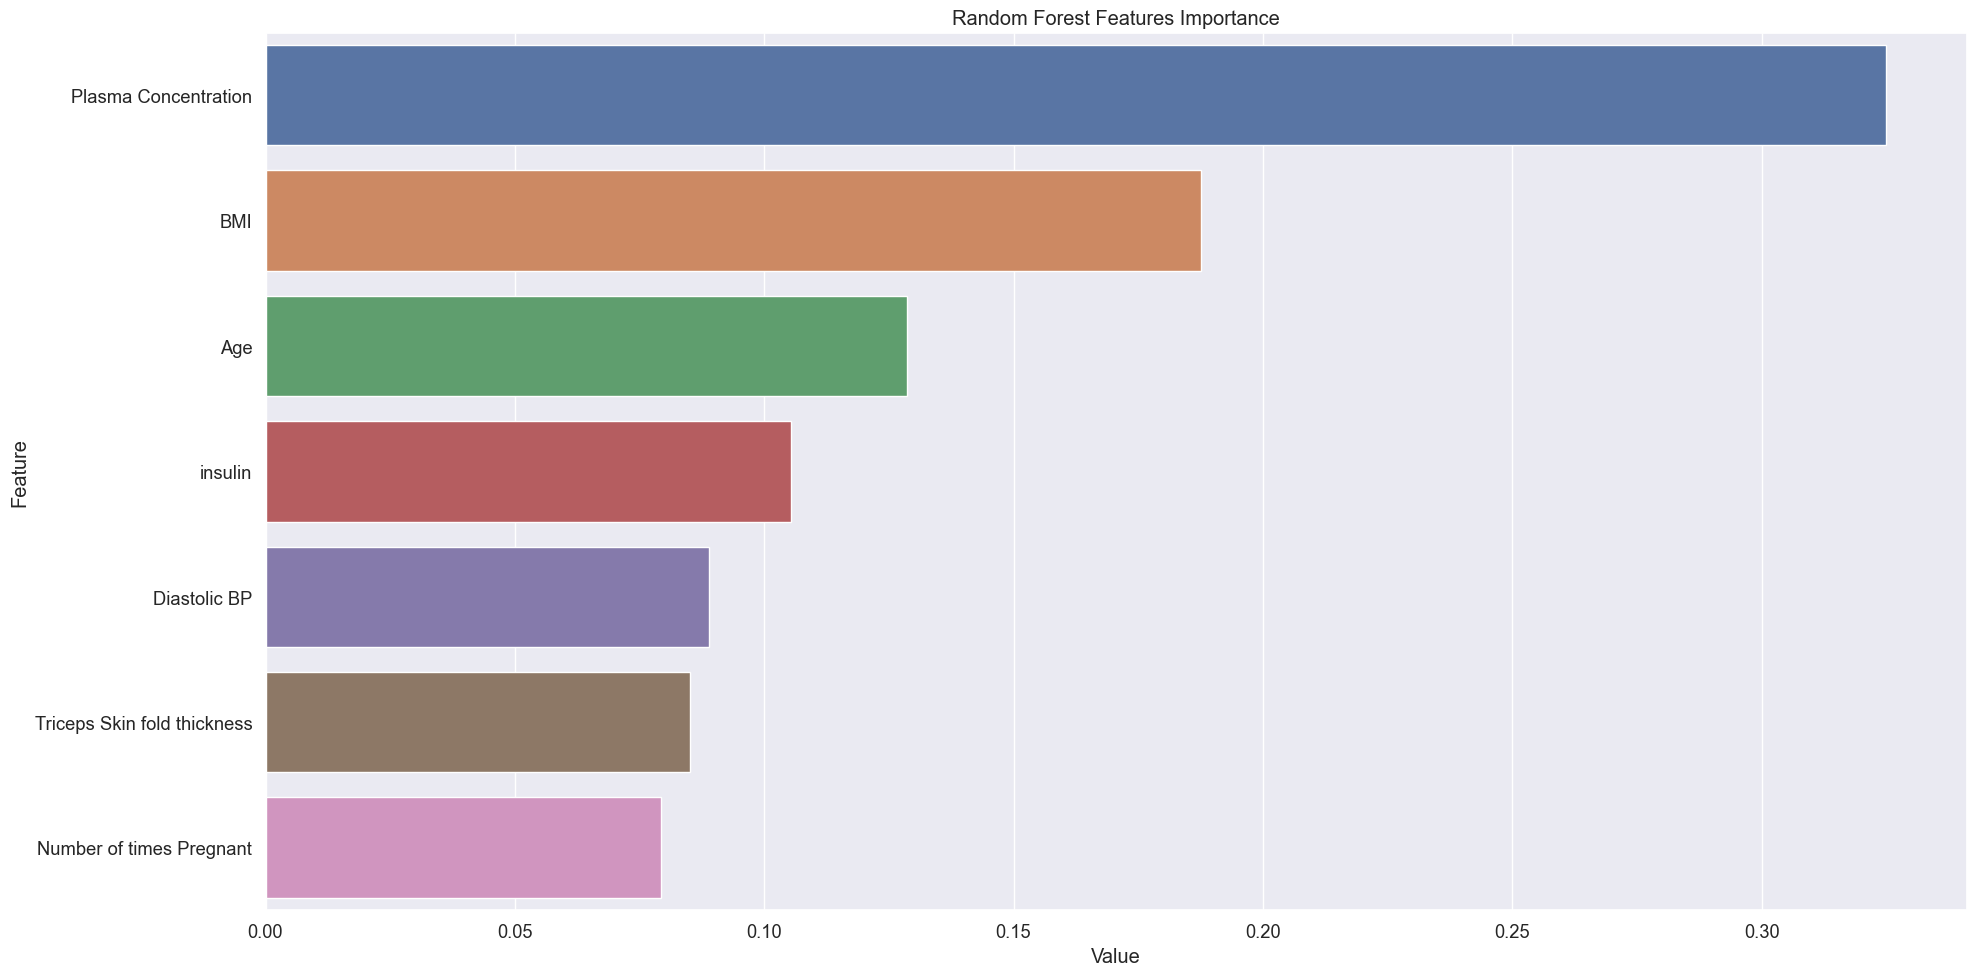

In [54]:
# Creating and saving feature importance curve
print("Creating and saving the feature importance curve!")
feature_imp = pd.DataFrame(sorted(zip(rf_featimp.feature_importances_,X.columns)), columns=['Value','Feature'])

plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('Random Forest Features Importance')
plt.tight_layout()

figure_name = f"rf_feature_importance_graph.png"
plt.savefig(figure_name)

In [59]:
DT_featimp = DecisionTreeClassifier(max_depth=5, min_samples_split=10)
DT_featimp.fit(X_train_sm, y_train_sm)

DecisionTreeClassifier(max_depth=5, min_samples_split=10)

Creating and saving the feature importance curve!


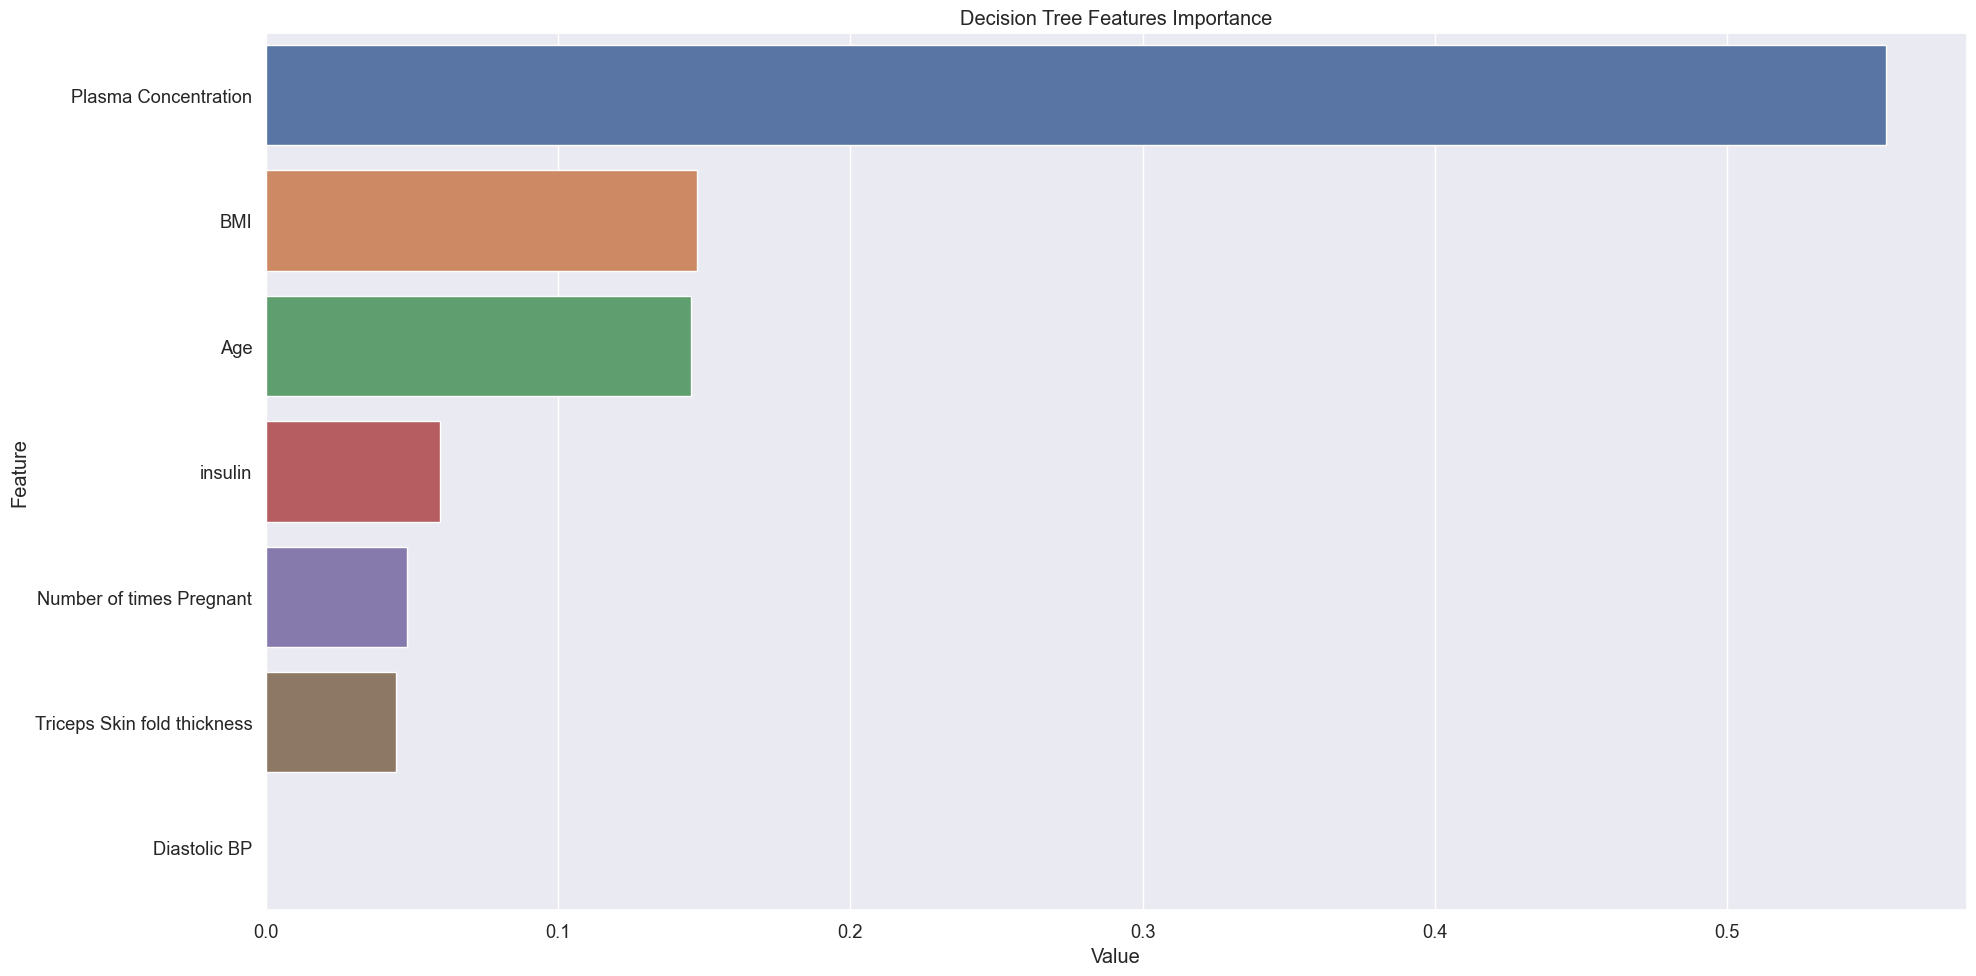

In [60]:
# Creating and saving feature importance curve
print("Creating and saving the feature importance curve!")
feature_imp = pd.DataFrame(sorted(zip(DT_featimp.feature_importances_,X.columns)), columns=['Value','Feature'])

plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('Decision Tree Features Importance')
plt.tight_layout()

figure_name = f"DT_feature_importance_graph.png"
plt.savefig(figure_name)

# END